# 521153S, Deep Learning assignment 2: Backpropagation, gradient check using linear approximation


## Outline 
#### In this assignment, you will learn:
* **Backpropagation**.
* Building a one layer NN using numpy to understand the backpropagation.
* Gradient check using finite-difference approximation.
* Stochatic Gradient Descent (SGD).
* Simple hype-parameters tuning methods to improve your NN performance.

#### Grading (<span style="color:green">15 points</span>)
In this assignment, we are going to learn about **backpropagation**. This is a very importance algorithm you need to know when building and training your neural network.
* **Part 1.** Import libraries, loading and preprocessing the training and testing data.
* **Part 2.** Backpropagation. (<span style="color:green">12 points</span>)
  * 2.1. Construct model in **Fig. 2** (<span style="color:green">4 points</span>) <br>
       * 2.1.1 Declare W1 and W2 (<span style="color:green">1.0 point</span>) <br>
       * 2.1.2 Implement sigmoid (<span style="color:green">1.0 point</span>) <br>
       * 2.1.3 Implement softmax (<span style="color:green">1.0 point</span>) <br>
       * 2.1.4 Implement the cross-entropy loss (<span style="color:green">1.0 point</span>) <br>
  * 2.2. Implement the forward-pass (<span style="color:green">2.0 point</span>) <br>
       * 2.2.1 Foward-pass in training (<span style="color:green">1.0 point</span>) <br>
       * 2.2.2 Call cross entropy loss in training (<span style="color:green">0.5 point</span>) <br>
       * 2.2.3 Forward-pass in testing (<span style="color:green">0.5 point</span>) <br>
  * 2.3. Implement SGD (<span style="color:green">2 point</span>) <br>
       * 2.3.1 Velocity (<span style="color:green">1.0 point</span>) <br>
       * 2.3.2 Update weights (<span style="color:green">1.0 point</span>) <br>
  * 2.4. Derivatives <br>
       * Derive equations <br>
  * 2.5. Implement the derivatives (<span style="color:green">4.0 points</span>) <br>
       * 2.5.1 Implement equation 8 (<span style="color:green">1.0 point</span>) <br>
       * 2.5.2 Implement equation 6 (<span style="color:green">0.5 point</span>) <br>
       * 2.5.3 Implement equation 10 (<span style="color:green">1.0 point</span>) <br>
       * 2.5.4 Implement equation 10+11 (<span style="color:green">1.0 point</span>) <br>
       * 2.5.5 Implement equation 7 (<span style="color:green">0.5 point</span>) <br>
* **Part 3.** Gradient check using finite-difference approximation. (<span style="color:green">0.5 points</span>) <br>
  * Question: why don't we use FDA to calculate the gradient to update our model? (<span style="color:green">0.5 point</span>) <br>
* **Part 4.** Regularization and NN simple tunning. (<span style="color:green">2.5 points</span>) <br>
  * 4.1. Applying weight decay. (<span style="color:green">1.5 point</span>) <br>
       * There are 3 spots you need to fill, (<span style="color:green">0.5 point</span>) each spot.
  * 4.2. Change the number of neurons in the hidden layer and report the performance (<span style="color:green">1 point</span>) <br>

#### Environment
Python 3, Numpy, matplotlib, sklearn

#### Dataset
* [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist)
is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. Using the Fashion-MNIST give you more room to wiggle your experiments.

#### Hints
* To find the place where you have to insert your solution, hit Crtl + F and search for **TODO:** . You are NOT suppose to modify the codes from other parts.
* **Be careful with the shape** of the weights, gradient, .. of your tensor in your implementation. Double check and make sure the shapes are fit for computation, especially matrix multiplication.

## Part 1. Import libraries, loading and preprocessing the training and testing data
**You don't need to change the code from this part.**

In [1]:
# You will mainly use numpy to construct your NN
import numpy as np
import matplotlib, time, copy, os, requests, zipfile, sys
# Matplotlib to plot the image
import matplotlib.pyplot as plt
# Off-the-shelf evaluation functions provided by sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
# Matplotlib predefined 'magic function'. It will include your graphs in your notebook, next to the code
%matplotlib inline

### Functions use to download the dataset from google drive
The code snipet was taken from [this thread](https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url).

In [2]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


### Functions use to pre-process your training/testing data

In [3]:
def reshape_train_data(X):
    ''' Input training data has shape (60000, 28, 28)
        Input testing data has shape (10000, 28, 28)
        where: 
        60000 is the numbers of input training samples
        10000 is the numbers of input testing samples
        similar to MNIST, resolution of each sample is 28 x 28
    '''
    samples, H, W = X.shape
    # Reshape input volume to (sample, 784), this mean, your NN input layer will have 784 placeholders
    # we scale the RGB values by divide them by 255, this will help improve the training performance
    return X.reshape(samples, H * W).T / 255

def one_hot_vector(x, num_classes):
    # By now, I think you already heard about this so many times
    return np.eye(num_classes)[x].T

### We took care of download the data for you.
The fashion-MNIST data will be download and store in your **work_dir/data/fashion_mnist_npy**

In [4]:
PATH = './data'
if not os.path.exists(PATH):
    os.makedirs(PATH)
    
    file_id = '1DQ2Nf2rY467kyZKOf_CG3Kib5FLv0xQu'
    destination = os.path.join(PATH, 'fashion_mnist_npy.zip')
    download_file_from_google_drive(file_id, destination)
    
    with zipfile.ZipFile(destination, 'r') as zip_ref:
        zip_ref.extractall(PATH)
        
    print("Data downloaded and extracted!")
    
    os.remove(destination)
    
else:
    print("Data was already downloaded and extracted!")

PATH = os.path.join(PATH, 'fashion_mnist_npy')

# The actual meaning of the label of your classes.
# E.g. if a output one-hot vector is [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], it used to prepresent a Dress
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Data downloaded and extracted!


### Finally, we load and preprocess the data

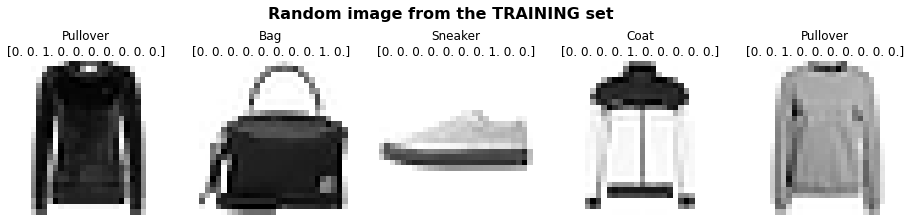

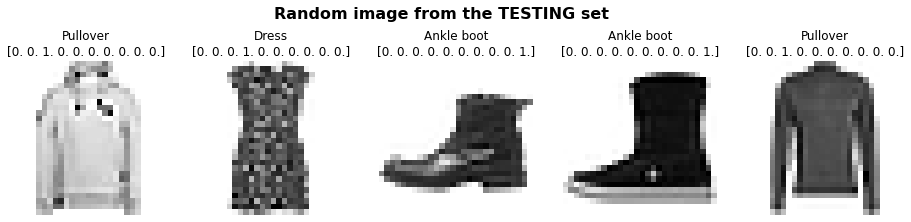

In [6]:
# Load the training input
X_train = np.load(os.path.join(PATH, 'train_data.npy'))
# Load the training labels
X_test = np.load(os.path.join(PATH, 'test_data.npy'))
# Load the testing input
Y_train = np.load(os.path.join(PATH, 'train_labels.npy'))
# Load the testing labels
Y_test = np.load(os.path.join(PATH, 'test_labels.npy'))

# Get the number of classes
num_classes = len(label_names)
# Get the number of training samples and their resolution for reshape
num_trains, HEIGHT, WIDTH = X_train.shape

# Reshape the training and testing inputs
X_train, X_test = reshape_train_data(X_train), reshape_train_data(X_test)

# Create one-hot vector for the training and testing labels
Y_train, Y_test = one_hot_vector(Y_train, num_classes), one_hot_vector(Y_test, num_classes)


# This part use to randomly load some of the training and testing image and the one-hot vectors for checking
fig_train, ax_train = plt.subplots(figsize=(16, 8), nrows=1, ncols=5)
fig_train.suptitle("Random image from the TRAINING set", y=0.73, fontsize=16, fontweight='bold')

fig_test, ax_test = plt.subplots(figsize=(16, 8), nrows=1, ncols=5)
fig_test.suptitle("Random image from the TESTING set", y=0.73, fontsize=16, fontweight='bold')

for idx in range(5):
    i, j = np.random.randint(num_trains), np.random.randint(X_test.shape[0])
    
    ax_train[idx].imshow(X_train[:,i].reshape(HEIGHT, WIDTH), cmap = matplotlib.cm.binary)
    ax_train[idx].set_title(label_names[np.argmax(Y_train[:,i])] + "\n" + str(Y_train[:,i]))
    ax_train[idx].axis('off')
    
    ax_test[idx].imshow(X_test[:,j].reshape(HEIGHT, WIDTH), cmap = matplotlib.cm.binary)
    ax_test[idx].set_title(label_names[np.argmax(Y_test[:,j])] + "\n" + str(Y_test[:,j]))
    ax_test[idx].axis('off')


## Part 2. Backpropagation (<span style="color:green">10 points</span>)
#### The fun part start from here.
*Definition:* backpropagation is an algorithm used to **calculate the gradient of a loss function** (sometime called cost function), by applying the chain rule, so that we can update the weights (and bias) of our neural network using optimizer such as gradient descent. <br>
It could be interpreted as the backward propagation (oppose to the forward propagation) of the network’s layers error, in which we calculate the error of the current layer, then pass the weighted error back to the previous layer, and recursively doing this until we travel back to the first hidden layer. At each layer, we update the weights using the derivative of the cost for each weight.

Let illustrate this concept using a simple toy example.

![](img/toy.png)
<center> <strong> <font size="3" color="blue"> Figure 1. Toy example of backpropagation </font> </strong> </center>

In **Fig. 1** we have a loss function $L$:
\begin{align}
L = c \times d
\end{align}

where <br>

\begin{align}
c = a + b -5
\end{align}

and, <br>

\begin{align}
d = b^2 + b -1
\end{align}

As illustrated in **Fig. 1**, the equations in the edge show the partial derivation of some functions with respect to their direct variables. For example, $\frac{\partial L}{\partial c}$ is the partial derivative of $L$ with respect to $c$. <br>
However, we are actually interested in calculate the derivative of $L$ with respect to $a$ and $b$, which don't directly connected with each other. So, how can we do this? As mentioned earlier, we can do this using the chain-rule so that we can calculate $\frac{\partial L}{\partial a}$ and $\frac{\partial L}{\partial b}$ as:

\begin{align}
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial c} \cdot \frac{\partial c}{\partial a}
\end{align}

and, <br>

\begin{align}
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial c} \cdot \frac{\partial c}{\partial b} + \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial b}
\end{align}

More importantly, **we can see that $a$ affect $L$ through $c$, and so on**. This concept hold no matter how many hidden layers you have or how complicated your loss will be as long as you use backpropagation to calculate the derivative to update your weights.

Now, let's get your hand dirty. Let's take a look at the model in **Fig. 2** below. This is the model we are gonna use in this assignment.

![](img/model.png)
<center> <strong> <font size="4" color="blue"> Figure 2. Structure of our neural network </font> </strong> </center>


### Construct model base on **Fig. 2** above (<span style="color:green">4 points</span>)
As shown in the **Fig. 2**, our neural network contains one hidden layer (we use 5 neurons as default setting) and an output layer. To further simply things, we will not include biases in our model. Be aware that, while the number of neuron in the hidden layer can be abitrary, there must be 10 neurons in the output layer because we want our model to classify images from 10 classes. Based on the **Fig. 2**, you have to construct your network. 

In [2]:
# Numbers of input units
num_input = X_train.shape[0]
# Number of neural in your hidden layer
# TODO: modify the number of neurons in the hidden layer
num_hidden = 5

# Construct your neural network from Fig. 2 (1.0 point)
# TODO: Random initialize the hidden layer weights (w/o bias)
# Hints: use np.random.randn()
W1 = np.random
# TODO: Random initialize the output layer weights (w/o bias)
W2 = 

def sigmoid(X):
    # TODO: implement Eq. 2 (1.0 point)
    # HintsL use np.exp()
    

def softmax(X):
    # TODO: implement Eq. 4 (1.0 point)
    # Hints: use np.exp() and np.sum() <- beware of the axis
    

def cross_entropy_loss(Y, Y_pred):
    # TODO: implement Eq. 5 (1.0 point)
    # Hints: use np.sum(), np.multiply() and np.log()
    

SyntaxError: invalid syntax (<ipython-input-2-e1fb03102b7e>, line 10)

According to the model in **Fig. 2**, our **forward-propagation** is going to start with the calculation of the output volume $A_1$ for the hidden layer:

\begin{align}
A_1 = \sigma(Z_1) = \sigma(W_1 X ) \tag{1}
\end{align}
where $W_1$ is the weights of the hidden layer, $X$ is the input, and $\sigma$ is the sigmoid activation where: <br>
\begin{align}
\sigma(x) = \frac{1}{1 + e^{-x}} \tag{2}
\end{align}

Then, we calculate the output volume of the output layer $A_2$ by: <br>
\begin{align}
A_2 = S(Z_2) = S(W_2 A_1) \tag{3}
\end{align}

In **Eq. 3**, $W_2$ is the weights of the output layer, $A_1$ is the output volume of the hidden layer, $S$ stands for softmax and defines by: <br>
\begin{align}
S(x_i) = \frac{e^{x_i}}{\sum_{j=0}^{k} e^{x_j} } \tag{4}
\end{align}
where $i=0,1,..,k$. We use $k$ to represent classes, and $k=9$ in our case.

Finally, we compute the loss function using:

\begin{align}
L(Y, A_2) = - \frac{1}{M} \sum_{k=0}^{M} \sum_{i=0}^{N} Y_i^{k} log({A_2}_i^{k}) \tag{5}
\end{align}

where $Y$ is the ground truth labels, $N$ is the number of classes, $M$ is the number of samples in the training batch.



### Derivative

Using what you learnt in undergraduate school, let's calculate the **backward-propagation** for our model in **Fig. 2**. <br>
As mentioned earlier, we are interested in $\frac{\partial L}{\partial W_1}$ and $\frac{\partial L}{\partial W_2}$, where: 

\begin{align}
\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial W_2} \tag{6}
\end{align}

and, <br> 

\begin{align}
\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial A_1} \cdot \frac{\partial A_1}{\partial Z_1} \cdot \frac{\partial Z_1}{\partial W_1} \tag{7}
\end{align}
 
From **Eq. 6** we have: <br>

The derivative of $L$ with respect to $Z_2$: 
\begin{align}
\frac{\partial L}{\partial Z_2} = \frac{\partial L}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} = A_2 - Y \tag{8}
\end{align}

The derivative of $Z_2$ with respect to $W_2$: 
\begin{align}
\frac{\partial Z_2}{\partial W_2} = A_1 \tag{9}
\end{align}

From **Eq. 7** we have: <br>

The derivative of $L$ with respect to $A_1$: 
\begin{align}
\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial A_1} = (A_2 - Y) W_2\tag{10}
\end{align}

The derivative of $A_1$ with respect to $Z_1$: 
\begin{align}
\frac{\partial A_1}{\partial Z_1} = (A_1) (1 - A_1) \tag{11}
\end{align}

The derivative of $Z_1$ with respect to $W_1$: 
\begin{align}
\frac{\partial Z_1}{\partial W_1} = X \tag{12}
\end{align}

## Part. 3 Gradient check using finite-difference approximation. (<span style="color:green">0.5 points</span>)

When training deep neural network, there are many things that can go wrong. Until this point, you probably notice that we have been going on and on about the gradient. Why? Because the gradient is very important. Hence, you must making sure that the calculation of your gradient is correct. A correct gradient calculation won't promise your model will converge, but if the calculation was wrong your model will perform very weird. This type of error is hard to debug, so we better prevent it beforehand. <br> 
To perform the gradient check, we can calculate gradient using the [finite-difference approximation](https://en.wikipedia.org/wiki/Finite_difference) (FDA), and let's call the output of FDA numerical gradients. Then we compare this numerical gradients with the gradient we calculate from taking the derivative. If the differences between them are small enough, we can assume that the gradient was calculated correctly. <br>

You probably learnt about FDA in your undergraduate, but to refresh your mind, let's have a simple example to see how FDA works. Assume that we have a function $f(x)$ which <br>

\begin{align}
f(x) = \frac{1}{3} x^3 - \frac{1}{2} x^2 + 1 \tag{13}
\end{align}

Then, the derivative $\Delta f$ will be: <br>
\begin{align}
\Delta f = x^2 - x \tag{14}
\end{align}

At $x=2.125$, using **Eq. 14** we have $\Delta f = 2.390625$

If we calculate the numerical gradient using FDA we have:
\begin{align}
\Delta_{num\_grad} f = \frac{f(x + \epsilon) - f(x - \epsilon)}{2 * \epsilon}  \tag{15}
\end{align}

where $\epsilon$ is a very small value (E.g. $\epsilon = 1e-{04}$)

At the same point $x=2.125$, using **Eq. 15** we have $\Delta_{num\_grad} f = 2.3906250033389753$ <br>

We can see that, the calculated values of $\Delta f$ and $\Delta_{num\_grad} f$ are very close to each other. <br>

With the same idea, we can check the gradient calculation of our network using FDA. A simple way to do this is: <br>
1) We wiggle (by a very small $\epsilon$ values) the value of our weight for all of the parameters in our model. By all parameters, I mean all of the weights of $W_1$ and $W_2$. E.g. if we use 5 neurons in the hidden layer, the number of parameters in our network is : <br> 
$num\_params(net) = num\_params(W_1) + num\_params(W_2) = 28*28*5 + 5*10 = 3970$ <br>
so we have to repeat the "wiggling" and calculate the numerical gradient 3970 times. At the end, we have a $num\_grad$ vector that have shape (3970,) <br>
2) Calculate the gradient by taking the derivative. Similarly, we will have a $grad$ vector that also have shape (3970,) <br>
3) Compare $num\_grad$ and $grad$ vectors by: <br>
\begin{align}
grad\_diff = \frac{|grad - num\_grad|_2}{|grad + num\_grad|_2}  \tag{16}
\end{align}

If **grad_diff** is smaller than $1e-{08}$ than we assume that our gradient calculation is correct.

### Question: Why don't we use FDA to calculate the gradient to update our model? (<span style="color:green">0.5 points</span>) <br>
 

**Answer:** 

### Hyper-parameters in your training

In [ ]:
# Flag use to enable/disable weight decay regularization
is_weight_decay = True

if is_weight_decay:
    # Setting lambda coefficient for weight decay
    lmda = np.exp(-7)

# Seting learning rate and momentum for SGD
learning_rate = 0.25
beta = 0.5

# Seting the number of training epochs
epoch = 50
# Choose your batch size
batch_size = 128
# Calculate the number of training iterations base on the number of training samples and your batch size
num_batchs = num_trains // batch_size

print("Num_trains: {}, num_batchs: {}".format(num_trains, num_batchs))


### Training your network (<span style="color:green">9.5 points</span>)

In this assignment, we will train our model using mini-batch stochatic gradient descent with momentum. To know more about this optimization algorithm, please check out this great [video](https://www.youtube.com/watch?v=k8fTYJPd3_I) from Dr. Andrew Ng. <br>
For this assignment, we will use the implementation from **Eq. 17** and **Eq. 18** <br>

\begin{align}
v_{dW} = \beta v_{dW} + (1 - \beta) dW \tag{17}
\end{align}
\begin{align}
W = W - \alpha v_{dW} \tag{18}
\end{align}

If you are curious, you can modify the hyper-params in the above section at your will.

In [ ]:
# Define an interactive ipython figure to display the training loss
%matplotlib notebook
fig = plt.figure("Training loss")
ax = fig.add_subplot(1, 1, 1)
plt.ion()
fig.show()
fig.canvas.draw()

# Log the training loss
loss_log = []

# Zeros initialize the momentum for SGD
V_dW1 = np.zeros(W1.shape)
V_dW2 = np.zeros(W2.shape)

# Training
for i in range(epoch):
    start_t = time.time()
    
    # Random shuffle training data every training epoch
    np.random.seed(np.random.randint(num_trains))
    indices = np.random.permutation(num_trains)
    X_train_shuffled, Y_train_shuffled = X_train[:, indices], Y_train[:, indices]

    for j in range(num_batchs):

        # Get mini-batch samples for training
        start_idx = j * batch_size
        end_idx = min(j * batch_size + batch_size, X_train.shape[1] - 1)
        X, Y = X_train_shuffled[:, start_idx : end_idx], Y_train_shuffled[:, start_idx : end_idx]
        # Size of actual mini-batch, it could be smaller than batch_size
        mini_batch = end_idx - start_idx
        
        # TODO: implement the forward-pass (1.0 point)
        Z1 = 
        A1 = 
        Z2 = 
        A2 = 
        

        if is_weight_decay: 
            # TODO: call cross entropy loss with weight decay regularization
            # (0.5 point)
            L =
            
        else:
            # TODO: call cross entropy loss (0.5 point)
            L =
            
        
        # Log the training loss during training
        loss_log.append(L)
        

        # TODO: calculate the derivative of 𝐿 with respect to 𝑍2 using eq. 8 (1.0 point)
        dZ2 = 
        
        if is_weight_decay:
            # TODO: calculate the derivative of 𝐿 with respect to W2 using eq. 6 with weight decay regularization
            # (0.5 point)
            dW2 =
            
        else:
            # TODO: calculate the derivative of 𝐿 with respect to W2 using eq. 6 (0.5 point)
            dW2 =
        
        
        # TODO: calculate the derivative of 𝐿 with respect to A1 using eq. 10 (1.0 point)
        dA1 = 
        
        # TODO: calculate the derivative of 𝐿 with respect to Z1 using eq. 10 and eq. 11 (1.0 point)
        dZ1 = 
        
        if is_weight_decay:
            # TODO: calculate the derivative of 𝐿 with respect to W1 using eq. 7 with weight decay regularization
            # (0.5 point)
            dW1 =
            
        else:
            # TODO: calculate the derivative of 𝐿 with respect to W1 using eq. 7 (0.5 point)
            dW1 =            
        
        # TODO: Update the learning velocity using Eq. 17 (1.0 point)
        V_dW1 = 
        V_dW2 = 

        # TODO: Update the model weights using Eq. 18 (1.0 point)
        W1 = 
        W2 = 

        if (j % 100 == 0):
            print("[Epoch/Iterations]:[{}/{}], loss: {}".format(i, j, L))
            
    ax.clear()
    ax.plot(loss_log)
    fig.canvas.draw()
    print("=> Elapsed time epoch #{} : {:.2f} seconds".format(i, time.time() - start_t))


### Evaluate the performance of your model (<span style="color:green">0.5 points</span>)

In [ ]:
# TODO: implement the forward-pass (0.5 point)
Z1 = 
A1 = 
Z2 = 
A2 = 

# Evaluate the performance of your NN
predictions = np.argmax(A2, axis=0)
labels = np.argmax(Y_test, axis=0)
print("Confusion matrix:\n{}".format(confusion_matrix(labels, predictions)))
print("Testing accuracy: {}".format(accuracy_score(labels, predictions)))

## Part 4. Regularization and NN simple tunning (<span style="color:green">2.5 points</span>)

1. Applying weight decay (<span style="color:green">1.5 point</span> )
  * Using what you learnt from assignment 1 to add the code at neccesary parts in **Training your network** and **Implement gradient check** above.
  * There are 3 spots, (<span style="color:green">0.5 point</span>) each spot. Insert the answers in above section.
2. Change the number of neurons in the hidden layer and report the performance (<span style="color:green">1 point</span>)

**Answer of question 2:**